# ISCE 2 Offsets Generation
<br>

This notebook is an interactive jupyter playground to set up your system and get the required files to generate dense ofsets using ISCE2. 

>**DISCLAIMER:** The setup for ISCE2 varies by system and is a very frustrating process. You will likely run into errors, refer to the UNAVCO tutorials from 2023 and 2024 for other setup and debugging tips.

There are 3 steps:
1. Environment setup
2. Downloading DEM
3. Ensure Files are setup properly

Once you run through this notebook and feel comfortable with the process, you can modify the contents of `offsets/run_isce2.py` to automate the process.

## Step 1: Make ISCE2 Environment and Set File Structure

First, we must make a persistent environment on CryoCloud that contains ISCE2 for processing and analysis purposes. To make offsets we still require TopsApp which relies on the ISCE2 architecture.

Then run the command below in terminal:
```bash
conda create --name isce2-test --file isce_requirements.txt
```

Next, we activate the environment, and install a few more packages:
```bash
conda activate isce2-test
conda install isce2 boto3 jupyter conda-build ipykernel
```

**If running on a cloud computing environment:** <br>
create a kernel with:
```bash
python -m ipykernel install --user --name isce2-test --display-name "IPython - ISCE2"
```

Once that runs, you can select the kernel from the upper right hand corner of the notebook toolbar. After selecting the kernel, the cell below should run:

In [1]:
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
import subprocess, shutil
import datetime
import glob
import sys
import os
from osgeo import gdal, osr
gdal.UseExceptions()
import scipy.ndimage as ndimage
import isce
from IPython import get_ipython

ERROR 1: /home/jovyan/envs/isce2/lib/python3.8/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /srv/conda/envs/notebook/lib/gdalplugins/../libgdal.so.35)
ERROR 1: /home/jovyan/envs/isce2/lib/python3.8/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /srv/conda/envs/notebook/lib/gdalplugins/../libgdal.so.35)
ERROR 1: /home/jovyan/envs/isce2/lib/python3.8/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /srv/conda/envs/notebook/lib/gdalplugins/../libgdal.so.35)
ERROR 1: /home/jovyan/envs/isce2/lib/python3.8/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /srv/conda/envs/notebook/lib/gdalplugins/../libgdal.so.35)
ERROR 1: /home/jovyan/envs/isce2/lib/python3.8/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /srv/conda/envs/notebook/lib/gdalplugins/../libgdal.so.35)
ERROR 1: /home/jovyan/envs/isc

Using default ISCE Path: /home/jovyan/envs/isce2/lib/python3.8/site-packages/isce


> **NOTE:** Running this cell once produces some warnings. Run the cell again to get rid of all warnings. This does not seem to be an issue in the processing later on in the notebook.

Next, we will update some of the environment variables. These changes will allow us to call ISCE modules from the command line. 

In [2]:
# Set Environment variables so that you can call ISCE from the command line
conda_path = '/home/jovyan'
isce_env = 'envs/isce2'

isce_home = f'{conda_path}/{isce_env}/lib/python3.8/site-packages/isce'
isce_stack = f'{conda_path}/{isce_env}/share/isce2'
isce_lib_path = f"{conda_path}/{isisce_env}/lib"

os.environ["LD_LIBRARY_PATH"] = f"{isce_lib_path}:{os.environ.get('LD_LIBRARY_PATH', '')}"
os.environ['ISCE_HOME'] = isce_home
os.environ['ISCE_STACK'] = isce_stack
os.environ['ISCE_ROOT'] = f'{conda_path}/{isce_env}/lib/python3.8/site-packages'

# Update PATH and PYTHONPATH
path_components = [
    f"{isce_home}/bin",
    f"{isce_home}/applications",
    f"{isce_stack}/topsStack",
    os.environ.get('PATH', '')
]
os.environ['PATH'] = ':'.join(filter(None, path_components))

pythonpath_components = [
    f'{conda_path}/{isce_env}/lib/python3.8/site-packages',
    isce_home,
    isce_stack,
    f"{isce_home}/applications",
    f"{isce_home}/components",
    os.environ.get('PYTHONPATH', '')
]
os.environ['PYTHONPATH'] = ':'.join(filter(None, pythonpath_components))

os.environ['OMP_NUM_THREADS'] = '8'

/srv/conda/envs/notebook/bin:/srv/conda/condabin:/home/jovyan/.local/bin:/srv/repo/.local/bin:/srv/conda/envs/notebook/bin:/srv/conda/bin:/srv/npm/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin/home/jovyan/envs/isce2/lib/python3.8/site-packages/isce/bin:/home/jovyan/envs/isce2/lib/python3.8/site-packages/isce/applications


> These will need to be set in every notebook or python script you plan to run ISCE2 with. 

### File Structure

This repository was cloned with the following file structure:

```
crevasse-advection/
├── figures/
├── offsets/
│   ├── aux/
│   ├── dem/
│   ├── orbits/
│   ├── SAFE/
│   └── run_isce2.py
├── 01-ISCE2_steup.ipynb
├── 02-run_topsApp.ipynb
├── 03-offset_postprocessing.ipynb
├── 04-derive_stress.ipynb
├── 05-advection_tracking.ipynb
├── 06-timeseries_decomposition.ipynb
├── isce_requirements.txt
├── environment.yml
└── README.md
```

When ISCE2 runs, it creates dozens of extra files and folders, which can get messy very fast. To contain the clutter, offsets will be generated from offsets folder, `crevasse-advection/offsets/`.

In [4]:
os.chdir('offsets/')  # move into the offsets folder
parent_dir = os.getcwd()

os.listdir()

FileNotFoundError: [Errno 2] No such file or directory: 'offsets/'

Getting a little bit ahead of ourselves here: we plan to make a timeseries of offsets. To further contain the files, each offset will be run in its own folder named by the two dates `YYYYMMDD-YYYYMMDD`.

By the end of processing, your directory will look something like:

```
offsets/
├── aux/
├── dem/
├── orbits/
├── SAFE/
├── 20201010-20201022/
│   ├── fine_offsets/
│   └── topsApp.xml
└── run_isce2.py
```

## Step 2: Getting a DEM

**Activate the Crevasse Advection kernel**

The ISCE2 environment is *not* compatible with `pdemtools`. The following cells will need to be run using a different environment.

In [1]:
!pip install pdemtools

In [2]:
import os

from shapely.geometry import Polygon
from pyproj import Transformer

import pdemtools as pdt
import matplotlib.pyplot as plt

In [3]:
# general shirase polygon from ASF below
# POLYGON((38.5117 -70.9317,41.8808 -69.9783,39.6027 -69.0519,36.2888 -69.9576,38.5117 -70.9317))

# Original coordinates (longitude, latitude) format
wgs84_coords = [
    (-70.9317, 38.5117),
    (-69.9783, 41.8808),
    (-69.0519, 39.6027),
    (-69.9576, 36.2888),
    (-70.9317, 38.5117)
]

# Create shapely polygon
wgs84_polygon = Polygon(wgs84_coords)

# Create transformer from EPSG:4326 to EPSG:3031
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=False)

# Transform coordinates
coords_3031 = [transformer.transform(lon, lat) for lon, lat in wgs84_coords]

# Create new polygon in EPSG:3031
polygon_3031 = Polygon(coords_3031)

# Get bounding box
bounds = polygon_3031.bounds
bounds

(1301627.0400722327,
 1635683.7503505899,
 1466628.3175475025,
 1772683.3600769506)

In [4]:
dem = pdt.load.mosaic(
    dataset='rema',  # must be `arcticdem` or `rema`
    resolution=10,        # must be 2, 10, or 32
    bounds=bounds,        # (xmin, ymin, xmax, ymax) or a shapely geometry
    version='v2.0',       # optional: desired version (defaults to most recent)
)

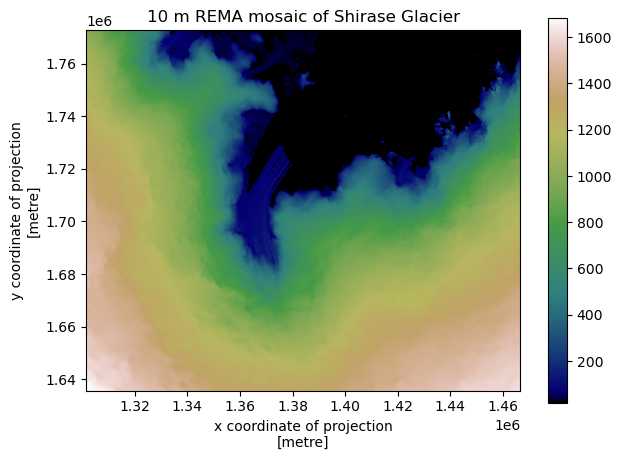

In [5]:
# sanity check that you have the right area of interest

fig, ax = plt.subplots(figsize=(7, 5))

dem.plot.imshow(ax=ax, cmap='gist_earth')

ax.set_aspect('equal')
ax.set_title('10 m REMA mosaic of Shirase Glacier')
plt.show()

In [19]:
dem_4326.rio.to_raster?

Signature:
dem_4326.rio.to_raster(
    raster_path: Union[str, os.PathLike],
    driver: Optional[str] = None,
    dtype: Union[str, numpy.dtype, NoneType] = None,
    tags: Optional[dict[str, str]] = None,
    windowed: bool = False,
    recalc_transform: bool = True,
    lock: Optional[bool] = None,
    compute: bool = True,
    **profile_kwargs,
) -> None
Docstring:
Export the DataArray to a raster file.

..versionadded:: 0.2 lock

Parameters
----------
raster_path: Union[str, os.PathLike]
    The path to output the raster to.
driver: str, optional
    The name of the GDAL/rasterio driver to use to export the raster.
    Default is "GTiff" if rasterio < 1.2 otherwise it will autodetect.
dtype: str, optional
    The data type to write the raster to. Default is the datasets dtype.
tags: dict, optional
    A dictionary of tags to write to the raster.
windowed: bool, optional
    If True, it will write using the windows of the output raster.
    This is useful for loading data in chunks

In [18]:
dem_4326 = dem.rio.reproject(4326)
dem_4326.rio.to_raster('offsets/dem/converted_dem.tif', driver='VRT')

RasterioIOError: Write failed. See previous exception for details.

In [40]:
source_crs = 'EPSG:3031'  # Antarctic Polar Stereographic

# Define target CRS (WGS84)
target_crs = 'EPSG:4326'  # WGS84

# Step 3: Calculate geotransform for the source data
# Calculate pixel size
x_res = (dem.x[-1] - dem.x[0]) / (len(dem.x) - 1)
y_res = (dem.y[-1] - dem.y[0]) / (len(dem.y) - 1)

# Define output filenames
output_base = "shirase_dem"
dem_file = f"{output_base}.dem"
vrt_file = f"{output_base}.vrt"
xml_file = f"{output_base}.xml"

In [39]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import Affine
from osgeo import gdal, osr
import os

# Step 4: Create and save the DEM file with proper georeference
def save_dem_with_projection(dem, output_file, source_crs, target_crs):
    # Get dimensions and values
    height, width = dem.shape
    
    # Create a geotransform (origin_x, pixel_width, 0, origin_y, 0, pixel_height)
    # Note: In the screenshot, y values appear to be decreasing (1.773e6 to 1.636e6)
    x_min = dem.x.values[0]
    y_max = dem.y.values[0]
    x_res = abs((dem.x.values[-1] - dem.x.values[0]) / (len(dem.x) - 1))
    y_res = abs((dem.y.values[-1] - dem.y.values[0]) / (len(dem.y) - 1))
    
    # Adjust y_res sign if y is decreasing
    if dem.y.values[0] > dem.y.values[-1]:
        y_res = -y_res
    
    # Create geotransform
    geotransform = (x_min, x_res, 0, y_max, 0, y_res)
    
    # Create output dataset
    driver = gdal.GetDriverByName('ENVI')
    dataset = driver.Create(
        output_file,
        width,
        height,
        1,  # Number of bands
        gdal.GDT_Float32  # Data type (float32 based on your data)
    )
    
    # Set geotransform and projection
    dataset.SetGeoTransform(geotransform)
    
    # Set source projection
    source_srs = osr.SpatialReference()
    source_srs.ImportFromEPSG(int(source_crs.split(':')[1]))
    dataset.SetProjection(source_srs.ExportToWkt())
    
    # Fill with data
    dataset.GetRasterBand(1).WriteArray(dem.values)
    dataset.GetRasterBand(1).SetNoDataValue(float(dem.attrs.get('_FillValue', -9999.0)))
    
    # Flush to disk
    dataset = None
    
    # Now create a warped version in WGS84
    wgs84_file = output_file.replace('.dem', '_wgs84.dem')
    warp_options = gdal.WarpOptions(
        srcSRS=source_crs,
        dstSRS=target_crs,
        resampleAlg=gdal.GRA_Bilinear
    )
    
    gdal.Warp(wgs84_file, output_file, options=warp_options)
    
    # Replace original file with warped version
    os.replace(wgs84_file, output_file)
    
    return output_file

# Step 5: Create an associated VRT file
def create_vrt_file(dem_file, vrt_file):
    """Create a VRT file that references the DEM"""
    # Open the DEM to get its properties
    ds = gdal.Open(dem_file)
    
    # Create the VRT
    vrt_ds = gdal.BuildVRT(vrt_file, [dem_file])
    vrt_ds = None
    
    return vrt_file

# Step 6: Create an associated XML metadata file
def create_xml_metadata(dem_file, xml_file, dem):
    """Create an XML metadata file for the DEM"""
    with open(xml_file, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write('<metadata>\n')
        f.write('  <dataset>\n')
        f.write(f'    <name>{os.path.basename(dem_file)}</name>\n')
        
        # Add dimensions
        f.write('    <dimensions>\n')
        f.write(f'      <x>{len(dem.x)}</x>\n')
        f.write(f'      <y>{len(dem.y)}</y>\n')
        f.write('    </dimensions>\n')
        
        # Add attributes from the xarray
        f.write('    <attributes>\n')
        for key, value in dem.attrs.items():
            f.write(f'      <{key}>{value}</{key}>\n')
        f.write('    </attributes>\n')
        
        # Add spatial reference
        f.write('    <spatial_reference>WGS84</spatial_reference>\n')
        
        f.write('  </dataset>\n')
        f.write('</metadata>\n')
    
    return xml_file

# Execute all the steps
try:
    # Save the DEM file with WGS84 projection
    print(f"Saving DEM file to {dem_file}...")
    save_dem_with_projection(dem, dem_file, source_crs, target_crs)
    
    # Create VRT file
    print(f"Creating VRT file {vrt_file}...")
    create_vrt_file(dem_file, vrt_file)
    
    # Create XML metadata file
    print(f"Creating XML metadata file {xml_file}...")
    create_xml_metadata(dem_file, xml_file, dem)
    
    print("Conversion complete!")
    
except Exception as e:
    print(f"Error during conversion: {str(e)}")

# For verification, read back the DEM file to check its properties
try:
    ds = gdal.Open(dem_file)
    if ds:
        print("\nVerification:")
        print(f"Size: {ds.RasterXSize}x{ds.RasterYSize}")
        print(f"Projection: {ds.GetProjection()}")
        print(f"GeoTransform: {ds.GetGeoTransform()}")
        
        # Read a sample of data
        band = ds.GetRasterBand(1)
        data_sample = band.ReadAsArray(0, 0, 10, 10)
        print(f"Data sample (10x10):\n{data_sample}")
        
        ds = None
except Exception as e:
    print(f"Error during verification: {str(e)}")

Saving DEM file to converted_dem.dem...
Creating VRT file converted_dem.vrt...
Creating XML metadata file converted_dem.xml...
Conversion complete!

Verification:
Size: 21447x7210
Projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (36.28862853067194, 0.0002607532777777778, 0.0, -69.05180701485756, 0.0, -0.0002607532777777778)
Data sample (10x10):
[[-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767